In [1]:
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt

dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

/Users/maximopasturensi/Desktop/untitled folder/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
df_ARG = df[df['job_country'] == 'Argentina']

In [7]:
df_skills = df_ARG.explode('job_skills')
df_skills = df_skills[['job_title_short', 'job_skills']]

In [12]:
# 1. Agrupamos y contamos
df_skill_count = df_skills.groupby(['job_skills', 'job_title_short']).size()

# 2. Reseteamos el índice (sin el argumento name)
df_skill_count = df_skill_count.reset_index()

# 3. Renombramos la columna de conteo (que por defecto se llama 0 o 'count')
df_skill_count = df_skill_count.rename(columns={0: 'skill_count', 'count': 'skill_count'})

# 4. Ordenamos por el nombre correcto: 'skill_count'
df_skill_count.sort_values(by='skill_count', ascending=False, inplace=True)

# 5. Mostramos el resultado
df_skill_count

,job_skills,job_title_short,skill_count
1054,sql,Data Engineer,1424
822,python,Data Engineer,1401
823,python,Data Scientist,1048
1055,sql,Data Scientist,930
71,aws,Data Engineer,803
...,...,...,...
730,pascal,Software Engineer,1
528,kotlin,Business Analyst,1
529,kotlin,Cloud Engineer,1
356,gdpr,Business Analyst,1


In [13]:
job_titles = df_skill_count['job_title_short'].unique().tolist()

job_titles = sorted(job_titles[:3])

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

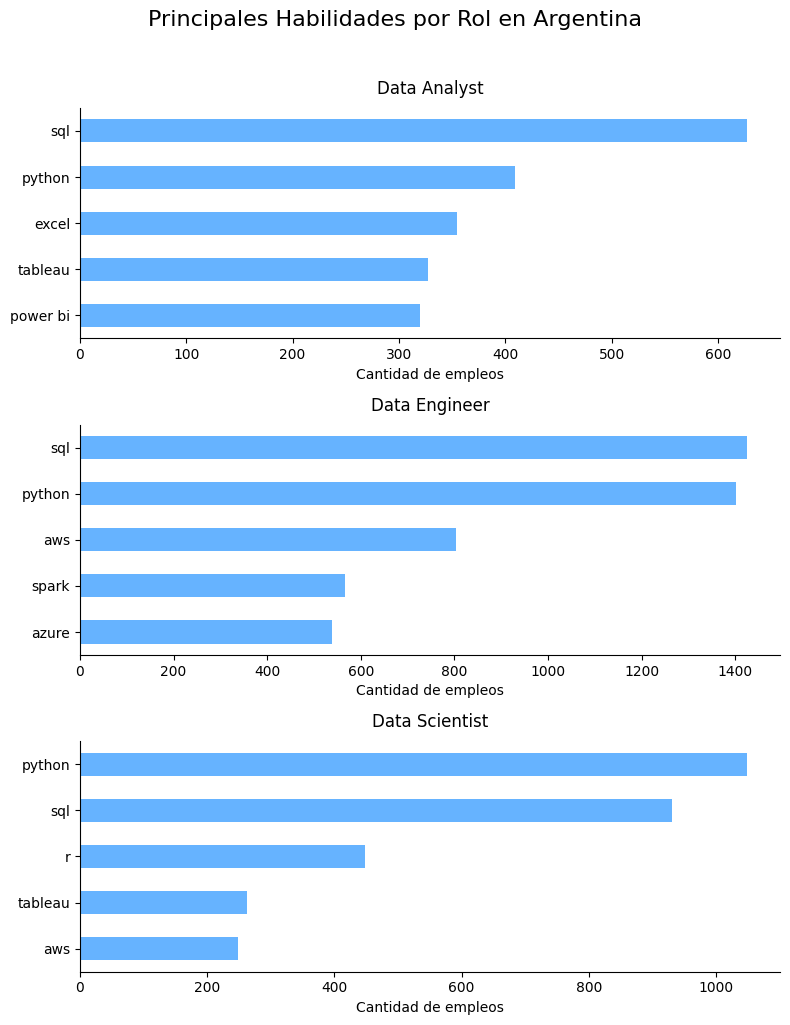

In [17]:
# 1. Ajustamos el tamaño de la figura (figsize) para que sea más alta y no se amontone
fig, ax = plt.subplots(len(job_titles), 1, figsize=(8, 10))

for i, job_title in enumerate(job_titles):
    df_plot = df_skill_count[df_skill_count['job_title_short'] == job_title].head(5)
    
    # Usamos un color amigable y quitamos la leyenda de una vez
    df_plot.plot(kind='barh', x='job_skills', y='skill_count', ax=ax[i], color='#66b3ff')
    
    # Configuraciones de cada subgráfico
    ax[i].set_title(job_title, fontsize=12, pad=10) # Añadimos 'pad' para separar el título
    ax[i].invert_yaxis()
    ax[i].set_ylabel('')
    ax[i].set_xlabel('Cantidad de empleos') # Siempre es bueno saber qué es el eje X
    ax[i].legend().set_visible(False)
    
    # Quitamos las líneas innecesarias del recuadro (opcional, lo hace ver más limpio)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

# 2. El SUPERTÍTULO con un ajuste de posición (y)
fig.suptitle('Principales Habilidades por Rol en Argentina', fontsize=16, y=1.02)

# 3. LA CLAVE: tight_layout hace que nada se encime con nada
plt.tight_layout()
plt.show()


In [19]:
df_job_title_count = df_ARG['job_title_short'].value_counts().reset_index(name='job_total')

In [ ]:
df_skills_perc = pd.merge(df_skill_count, df_job_title_count, how='left', on='job_title_short')
df_skills_perc['skills_percent'] = 100 * df_skills_perc['skill_count'] / df_skills_perc['job_total']
df_skills_perc

,job_skills,job_title_short,skill_count,job_total,skills_percent
0,sql,Data Engineer,1424,2265,0.628698
1,python,Data Engineer,1401,2265,0.618543
2,python,Data Scientist,1048,1617,0.648114
3,sql,Data Scientist,930,1617,0.575139
4,aws,Data Engineer,803,2265,0.354525
...,...,...,...,...,...
1261,pascal,Software Engineer,1,1267,0.000789
1262,kotlin,Business Analyst,1,453,0.002208
1263,kotlin,Cloud Engineer,1,322,0.003106
1264,gdpr,Business Analyst,1,453,0.002208


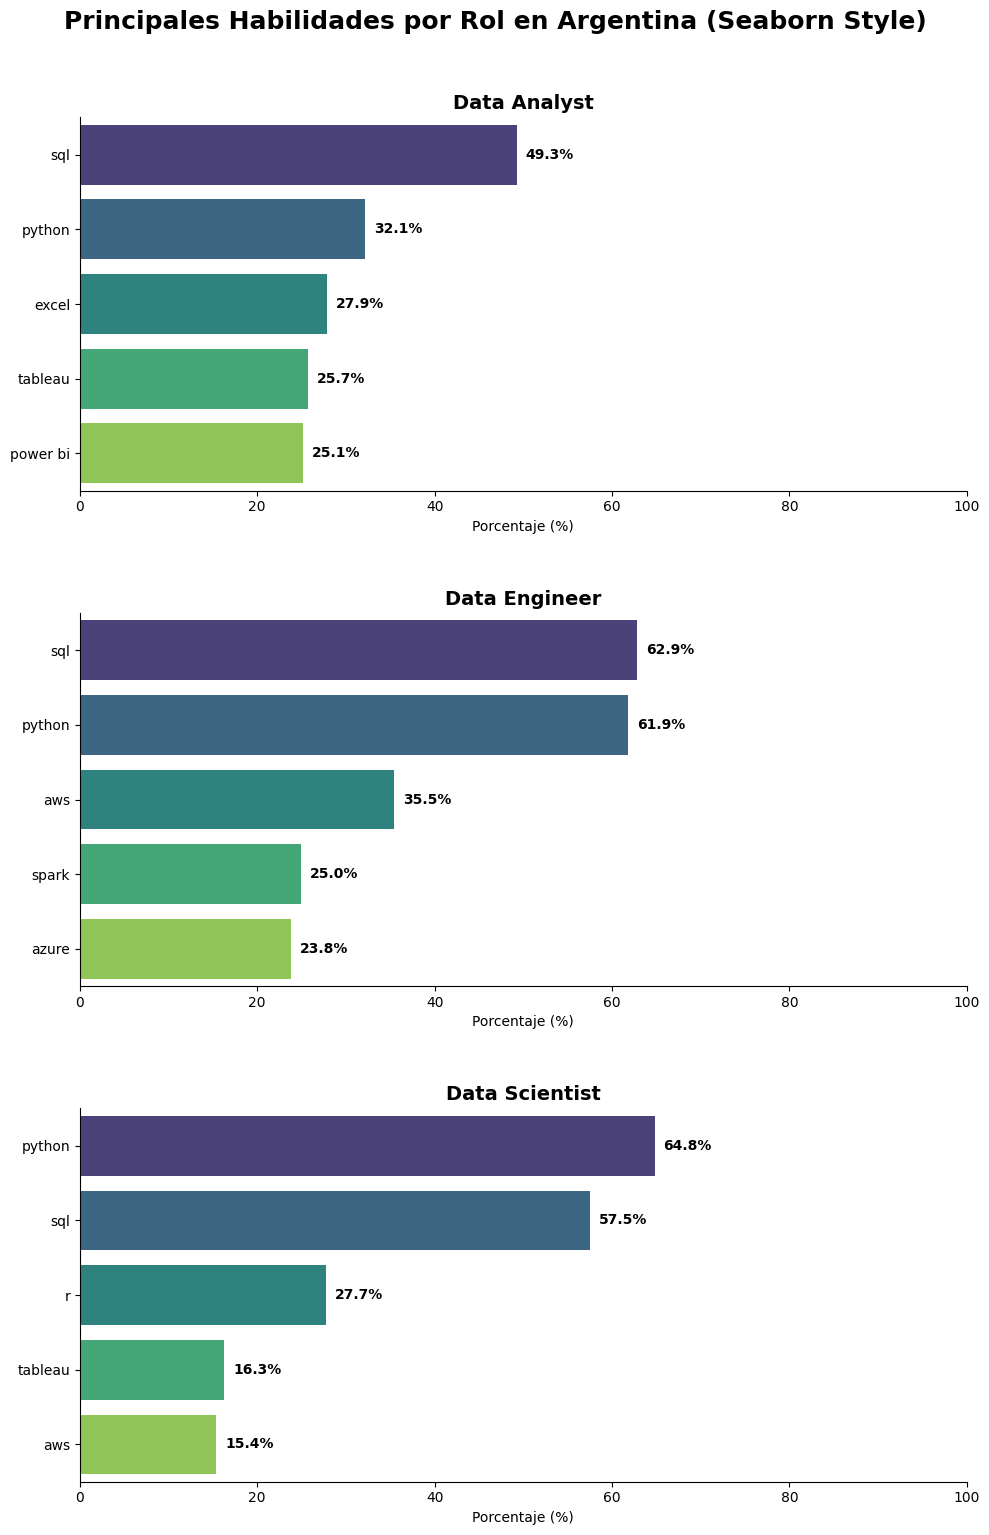

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Configuramos el lienzo
fig, ax = plt.subplots(len(job_titles), 1, figsize=(10, 15))

# Elegimos una paleta de colores (ej: 'viridis', 'Blues_r', 'coolwarm')
palette_name = "viridis"

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_perc[df_skills_perc['job_title_short'] == job_title].head(5).copy()
    
    # Aseguramos que los datos sean porcentajes (0-100)
    col_valor = df_plot.columns[-1]
    df_plot['perc_100'] = df_plot[col_valor] * 100
    
    # 2. GRAFICAMOS con Seaborn
    # 'hue' asigna un color distinto a cada barra basado en la habilidad
    sns.barplot(
        data=df_plot, 
        x='perc_100', 
        y='job_skills', 
        ax=ax[i], 
        palette=palette_name,
        hue='job_skills', # Esto activa los colores por categoría
        legend=False
    )
    
    # 3. Agregamos los textos (igual que antes)
    for n, v in enumerate(df_plot['perc_100']):
        ax[i].text(v + 1, n, f'{v:.1f}%', va='center', fontweight='bold')
    
    # Estética
    ax[i].set_title(job_title, fontsize=14, fontweight='bold')
    ax[i].set_xlim(0, 100)
    ax[i].set_xlabel('Porcentaje (%)')
    ax[i].set_ylabel('')
    
    # Quitamos bordes para que sea más limpio
    sns.despine(ax=ax[i])

fig.suptitle('Principales Habilidades por Rol en Argentina (Seaborn Style)', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout(h_pad=4.0)
plt.show()

In [42]:
print(df_skills_perc.head())

  job_skills job_title_short  skill_count  job_total  skills_percent
0        sql   Data Engineer         1424       2265        0.628698
1     python   Data Engineer         1401       2265        0.618543
2     python  Data Scientist         1048       1617        0.648114
3        sql  Data Scientist          930       1617        0.575139
4        aws   Data Engineer          803       2265        0.354525
